# Introduction

In this tutorial, we'll be walking through the Tensorflow code behind creating a convolutional neural network. If you'd like more of a conceptual view of how these networks work, check out my [blog post](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/). A CNN tutorial from the Tensorflow docs can also be found [here](https://www.tensorflow.org/tutorials/deep_cnn).

In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(os.environ['DATA_DIR']+os.sep+'MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Inputs and Outputs

So, in this next step, we're just going to create a session. Your x and y_ are just going to place placeholders that basically just indicate the type of input you want in your CNN and the type of output. For each of these placeholders, you have to specify the type and the shape. 

In [3]:
tf.reset_default_graph() 
sess = tf.InteractiveSession()
x = tf.placeholder("float", shape = [None, 28,28,1]) #shape in CNNs is always None x height x width x color channels
y_ = tf.placeholder("float", shape = [None, 10]) #shape is always None x number of classes

# Network Architecture

Now that we have our placeholders, we just have to specify the network architecture. Basically, the main point we have to remember is that all of the filters (weights) and biases are tensorflow variables. Let's create our filter and bias for the first layer

In [4]:
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))#shape is filter x filter x input channels x output channels
b_conv1 = tf.Variable(tf.constant(.1, shape = [32])) #shape of the bias just has to match output channels of the filter

Now that we have our filter and our bias, we can call our first conv layer. The 4 arguments you have to specify are the input (which is where our placeholder comes into play), the filter (we just created the variable for that), the stride, and the padding

In [6]:
print x
print W_conv1
h_conv1 = tf.nn.conv2d(input=x, filter=W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1
h_conv1 = tf.nn.relu(h_conv1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

Tensor("Placeholder:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("Variable/read:0", shape=(5, 5, 1, 32), dtype=float32)


This just defines some methods to make the function calls a little nicer. 

In [7]:
def conv2d(x, W):
  return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

Now, let's just complete the network

In [8]:
#Second Conv and Pool Layers
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(.1, shape = [64]))
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#First Fully Connected Layer
W_fc1 = tf.Variable(tf.truncated_normal([7 * 7 * 64, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(.1, shape = [1024]))
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#Dropout Layer
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#Second Fully Connected Layer
W_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(.1, shape = [10]))

#Final Layer
y = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

Now, let's formulate our loss function

In [9]:
crossEntropyLoss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_, logits = y))

Now, we need to use an optimizer to minimize the function

In [10]:
trainStep = tf.train.AdamOptimizer().minimize(crossEntropyLoss)

The following are the statements that help with calculating accuracy

In [11]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

The next line is the main statement that gets initializes all the variables we've declared earlier

In [12]:
sess.run(tf.global_variables_initializer())

This is code to allow us to visualize our training with Tensorboard

In [35]:
tf.summary.scalar('Cross Enropy Loss', crossEntropyLoss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = os.environ['TRAINING_DIR']+os.sep + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

(1, 784)
Tensor("Reshape_4:0", shape=(1, 28, 28, 1), dtype=float32)


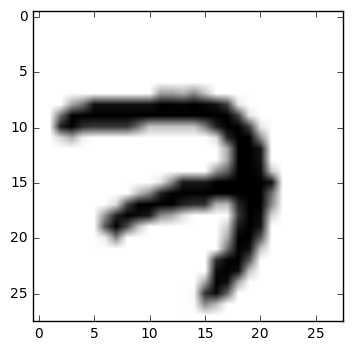

In [13]:
b = mnist.train.next_batch(1)
print b[0].shape #b[0] contains the image
image = tf.reshape(b[0], [-1,28,28,1])
print image
my_img = image.eval() #here is your image Tensor
my_i = my_img.squeeze()
plt.imshow(my_i, cmap='gray_r')
plt.show()

# Training

In [14]:
batchSize = 50
for i in range(1000):
    batch = mnist.train.next_batch(batchSize)
    trainingInputs = batch[0].reshape([batchSize,28,28,1])
    trainingLabels = batch[1]
    if i%10 == 0:
        summary = sess.run(merged, {x: trainingInputs, y_: trainingLabels, keep_prob: 1.0})
        writer.add_summary(summary, i)
    if i%100 == 0:
        trainAccuracy = accuracy.eval(session=sess, feed_dict={x:trainingInputs, y_: trainingLabels, keep_prob: 1.0})
        print "step %d, training accuracy %g"%(i, trainAccuracy)
    trainStep.run(session=sess, feed_dict={x: trainingInputs, y_: trainingLabels, keep_prob: 0.5})

step 0, training accuracy 0.04
step 100, training accuracy 0.94
step 200, training accuracy 0.98
step 300, training accuracy 0.9
step 400, training accuracy 0.96
step 500, training accuracy 0.98
step 600, training accuracy 1
step 700, training accuracy 0.98
step 800, training accuracy 1
step 900, training accuracy 1


# Testing

In [15]:
testInputs = mnist.test.images.reshape([-1, 28, 28, 1])
testLabels = mnist.test.labels
acc = accuracy.eval(feed_dict = {x: testInputs, y_: testLabels, keep_prob: 1.0})
print("testing accuracy: {}".format(acc))

testing accuracy: 0.984700024128
